# Step 0: Imports and Loading the Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble, neighbors
import string

import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jphillips3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jphillips3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
!pip install spacy

!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Pleaseuse the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!pip install nltk

In [4]:
# Load the data
listings = pd.read_csv('https://raw.githubusercontent.com/jphil-16/Thinkful_Projects_JDP/main/listings.csv')

In [5]:
# Drop the features that won't be used
listings = listings.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped',
       'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms', 'bedrooms',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'])

# Take a quick look at the data
listings.head()

,name,description,neighborhood_overview,host_response_time,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,bathrooms_text,beds,amenities,price,number_of_reviews,last_review,review_scores_rating,instant_bookable,reviews_per_month
0,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",Madrona is a hidden gem of a neighborhood. It ...,within a day,t,Central Area,Entire home/apt,9,2.5 baths,4.0,"[""Children\u2019s books and toys"", ""Iron"", ""Ha...",$295.00,32,2020-02-01,100.0,f,0.22
1,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",within a few hours,t,Other neighborhoods,Private room,2,3 shared baths,2.0,"[""Iron"", ""Hangers"", ""Lock on bedroom door"", ""H...",$55.00,148,2019-12-27,93.0,f,1.19
2,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,within a day,t,West Seattle,Entire home/apt,4,1 bath,3.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Private...",$155.00,40,2019-12-30,100.0,f,0.37
3,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,within a day,t,West Seattle,Entire home/apt,3,1 bath,2.0,"[""Conditioner"", ""Iron"", ""TV"", ""Hangers"", ""Cabl...",$125.00,53,2020-08-31,100.0,f,0.50
4,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",within a few hours,f,Other neighborhoods,Entire home/apt,4,1 bath,4.0,"[""Iron"", ""TV"", ""Hangers"", ""Cable TV"", ""Hair dr...",$100.00,97,2020-09-28,91.0,f,0.85


In [6]:
# See what columns are left
listings.columns

Index(['name', 'description', 'neighborhood_overview', 'host_response_time',
       'host_is_superhost', 'neighbourhood_group_cleansed', 'room_type',
       'accommodates', 'bathrooms_text', 'beds', 'amenities', 'price',
       'number_of_reviews', 'last_review', 'review_scores_rating',
       'instant_bookable', 'reviews_per_month'],
      dtype='object')

# Step 1: Clean the Text Data

In [7]:
# First things first - drop the rows that have empty values
# We can afford this step because we will still have thousands of data entires
listings = listings.dropna()
listings.reset_index(drop = True, inplace = True)

In [8]:
# Clean the text
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation that spaCy doesn't
    # recognize: the double dash '--'. Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text

listings["description"] = listings["description"].apply(lambda x: text_cleaner(x))
listings["description"].head(10)

NameError: name 're' is not defined

In [ ]:
listings["description"].tail(20)

In [9]:
# remove punctuation
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

listings["description"] = listings["description"].apply(lambda x: remove_punctuation(x))
listings["description"].head(10)

0    Gorgeous architect remodeled Dutch Colonial in...
1    Keeping you safe is our priority we are adheri...
2    The Sweet Orange is a delightful and spacious ...
3    Welcome to my delicious Tangerine Dream  A col...
4    We are in a great neighborhood quiet full of g...
5    Our twobedroom home is nestled in a quiet neig...
6    Make a request to stay for 5 day minimum and W...
7    Great location in West Seattle Fully furnished...
8    Step onto the private balcony of this condo fo...
9    Social Distancing extra Covid precautions in p...
Name: description, dtype: object

In [10]:
# tokenization
tokenizer = RegexpTokenizer(r'\w+')
listings["description"] = listings["description"].apply(lambda x: tokenizer.tokenize(x.lower()))
listings["description"].head(10)

0    [gorgeous, architect, remodeled, dutch, coloni...
1    [keeping, you, safe, is, our, priority, we, ar...
2    [the, sweet, orange, is, a, delightful, and, s...
3    [welcome, to, my, delicious, tangerine, dream,...
4    [we, are, in, a, great, neighborhood, quiet, f...
5    [our, twobedroom, home, is, nestled, in, a, qu...
6    [make, a, request, to, stay, for, 5, day, mini...
7    [great, location, in, west, seattle, fully, fu...
8    [step, onto, the, private, balcony, of, this, ...
9    [social, distancing, extra, covid, precautions...
Name: description, dtype: object

In [11]:
# Remove stop words
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

listings["description"] = listings["description"].apply(lambda x: remove_stopwords(x))
listings["description"].head(10)

0    [gorgeous, architect, remodeled, dutch, coloni...
1    [keeping, safe, priority, adhering, stringent,...
2    [sweet, orange, delightful, spacious, 2, br1ba...
3    [welcome, delicious, tangerine, dream, colorfu...
4    [great, neighborhood, quiet, full, gardens, wa...
5    [twobedroom, home, nestled, quiet, neighborhoo...
6    [make, request, stay, 5, day, minimum, reduce,...
7    [great, location, west, seattle, fully, furnis...
8    [step, onto, private, balcony, condo, peekaboo...
9    [social, distancing, extra, covid, precautions...
Name: description, dtype: object

In [12]:
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

listings["description"] = listings["description"].apply(lambda x: word_stemmer(x))
listings["description"].head(10)

0    gorgeou architect remodel dutch coloni heart m...
1    keep safe prioriti adher stringent cdc guideli...
2    sweet orang delight spaciou 2 br1ba home urban...
3    welcom delici tangerin dream color cozi 900 sq...
4    great neighborhood quiet full garden walkabl s...
5    twobedroom home nestl quiet neighborhood north...
6    make request stay 5 day minimum reduc cost 50 ...
7    great locat west seattl fulli furnish common a...
8    step onto privat balconi condo peekaboo view e...
9    social distanc extra covid precaut place br gr...
Name: description, dtype: object

# Step 2: Clean the Numerical Data

In [13]:
# Next we have to transform numerical columns that are currently in string form

# The listing price needs to be converted from a string to a number
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# The "last review" date needs the first 4 digits extracted to give us the year of the last review
# We will use this to filter out abandoned listings later on
year_last_review = pd.DataFrame([listings.loc[i,'last_review'][:4] for i in range(len(listings))])
year_last_review.columns = ['year_last_review']
listings = pd.concat([listings, year_last_review], axis = 1, sort = False)

# The number of bathrooms is stored as text
# This method of extracting the number treats full baths and half baths as the same
num_baths = pd.DataFrame([listings.loc[i,'bathrooms_text'][:1] for i in range(len(listings))])
num_baths.columns = ['num_baths']
listings = pd.concat([listings, num_baths], axis = 1, sort = False)

In [14]:
# We still need to transform the bathroom count from a string to an integer
for i in range(len(listings)):
  if listings.loc[i,'num_baths'] == 'H':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i, 'num_baths'] == 'P':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i, 'num_baths'] == 'S':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i,'num_baths'] == '1':
    listings.loc[i, 'num_baths'] = 1
  if listings.loc[i, 'num_baths'] == '2':
    listings.loc[i, 'num_baths'] = 2
  if listings.loc[i, 'num_baths'] == '0':
    listings.loc[i, 'num_baths'] = 0
  if listings.loc[i,'num_baths'] == '3':
    listings.loc[i, 'num_baths'] = 3
  if listings.loc[i, 'num_baths'] == '4':
    listings.loc[i, 'num_baths'] = 4
  if listings.loc[i, 'num_baths'] == '5':
    listings.loc[i, 'num_baths'] = 5
  if listings.loc[i, 'num_baths'] == '6':
    listings.loc[i, 'num_baths'] = 6
  if listings.loc[i, 'num_baths'] == '7':
    listings.loc[i, 'num_baths'] = 7

In [15]:
# Next we take all of the features with categorical data and use one-hot encoding
listings = pd.concat([listings,pd.get_dummies(listings.host_is_superhost, prefix="superhost", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.room_type, prefix="room_type", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.neighbourhood_group_cleansed, prefix="neighborhood", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.host_response_time, prefix="response_time", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.instant_bookable, prefix="instant_bookable", drop_first=True)], axis=1)
listings = pd.concat([listings,pd.get_dummies(listings.num_baths, prefix="num_baths", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(listings.host_is_superhost, prefix="superhost", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.room_type, prefix="room_type", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.neighbourhood_group_cleansed, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.host_response_time, prefix="response_time", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.instant_bookable, prefix="instant_bookable", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(listings.num_baths, prefix="num_baths", drop_first=True).columns)

In [16]:
# Now we need to filter out data that we don't want

# Filter on price first
# Drop rows with expensive listings (We will use $400 as a manual cut-off)
index_names_highprice = listings[listings['price'] > 400 ].index 
listings.drop(index_names_highprice, inplace = True)

# Filter on room type
# Drop rows with hotel rooms (there are very few of these and they are priced very differently)
index_names_hotel = listings[listings['room_type_Hotel room'] == 1 ].index 
listings.drop(index_names_hotel, inplace = True)

# Filter on last review date
# Drop rows with no recent reviews (which represent abandoned listings)
index_names_old = listings[listings['year_last_review'] != '2020' ].index 
listings.drop(index_names_old, inplace = True)

# Step 3: Explore the Data

In [17]:
len(listings)

1975

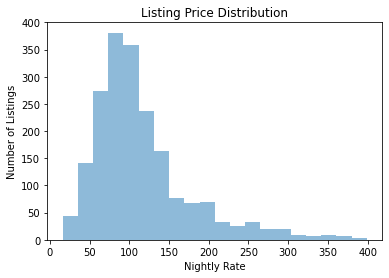

In [18]:
# Take a quick look at how the target variable is distrubted
plt.hist(listings['price'], alpha = .5, bins = 20)
plt.title('Listing Price Distribution')
plt.xlabel('Nightly Rate')
plt.ylabel('Number of Listings')
plt.show()

In [19]:
# Let's take another quick look at what our data looks like after all that...
listings.head()

,name,description,neighborhood_overview,host_response_time,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,bathrooms_text,beds,...,response_time_within a day,response_time_within a few hours,response_time_within an hour,instant_bookable_t,num_baths_1,num_baths_2,num_baths_3,num_baths_4,num_baths_5,num_baths_6
0,Casa Madrona - Urban Oasis 1 block from the park!,gorgeou architect remodel dutch coloni heart m...,Madrona is a hidden gem of a neighborhood. It ...,within a day,t,Central Area,Entire home/apt,9,2.5 baths,4.0,...,1,0,0,0,0,1,0,0,0,0
3,The Coolest Tangerine Dream MIL!,welcom delici tangerin dream color cozi 900 sq...,The neighborhood is the best of two worlds...w...,within a day,t,West Seattle,Entire home/apt,3,1 bath,2.0,...,1,0,0,0,1,0,0,0,0,0
4,"the down home , spacious, central and fab!",great neighborhood quiet full garden walkabl s...,"if you arrive early for check in at 3, I reco...",within a few hours,f,Other neighborhoods,Entire home/apt,4,1 bath,4.0,...,0,1,0,0,1,0,0,0,0,0
8,Stylish Oasis in a Prime Location in Belltown,step onto privat balconi condo peekaboo view e...,The condo is in the lively neighborhood of Bel...,within an hour,t,Downtown,Entire home/apt,6,1 bath,2.0,...,0,0,1,1,1,0,0,0,0,0
9,"Beautiful, Private Spot in Quiet Ballard",social distanc extra covid precaut place br gr...,Great walking neighborhood! We are in between...,within an hour,t,Ballard,Entire home/apt,4,1 bath,2.0,...,0,0,1,1,1,0,0,0,0,0


# Step 4a/5a: Use BoW to Convert the Text Features and generate models

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(listings["description"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
descriptions = pd.concat([bow_df, listings[["description", "host_is_superhost"]]], axis=1)

In [21]:
descriptions = descriptions.dropna()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

Y = descriptions['host_is_superhost']
X = np.array(descriptions.drop(['description','host_is_superhost'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9937952430196484

Test set score: 0.6124031007751938
----------------------Random Forest Scores----------------------
Training set score: 0.9948293691830403

Test set score: 0.6790697674418604
----------------------Gradient Boosting Scores----------------------
Training set score: 0.8210961737331954

Test set score: 0.6744186046511628


# Step 4b/5b: Use TF-IDF to Convert the Text Features and generate models

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)


# Applying the vectorizer
X = vectorizer.fit_transform(listings["description"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
descriptions = pd.concat([bow_df, listings[["description", "host_is_superhost"]]], axis=1)

In [24]:
descriptions = descriptions.dropna()

In [25]:
Y = descriptions['host_is_superhost']
X = np.array(descriptions.drop(['description','host_is_superhost'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9937952430196484

Test set score: 0.6124031007751938
----------------------Random Forest Scores----------------------
Training set score: 0.9948293691830403

Test set score: 0.6821705426356589
----------------------Gradient Boosting Scores----------------------
Training set score: 0.8231644260599793

Test set score: 0.6744186046511628
